## Лабораторна робота №3

**Тема**: REINFORCE, Actor-Critic

**Виконав:** студент групи КМ-12 Пономаренко Олександр

***Підгрупа №3***

Допустимі бібліотеки для реалізації лабораторної роботи: 
- gym,  gymnasium,  ale-py  –  бібліотека  з  середовищами  для  навчання  з 
підкріпленням; 
- tensorflow,  pytorch,  keras  –  бібліотеки  для  створення,  навчання  і 
застосування нейронних мереж; 
- numpy – бібліотека для математичних обчислень; 
- matplotlib, seaborn – бібліотеки для побудови графіків.

In [61]:
import os
import warnings

In [65]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [63]:
import numpy as np
import random
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.optim as optim

In [64]:
torch._dynamo.config.suppress_errors = True
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

#### 0.  Для  обраного  у  лабораторній  роботі  №2  середовища  реалізувати наступні методи навчання з підкріпленням: 
- І підгрупа: REINFORCE, REINFORCE+baseline 
- ІІ підгрупа: REINFORCE, Actor-Critic (однокроковий) 
- **ІІІ підгрупа: REINFORCE+baseline, Actor-Critic (однокроковий).**

Для апроксимації функцій ціни стану $v(s)$ та $\pi(a|s)$ використовувати нейронні мережі.

Структура нейронної мережі для функції $\pi(a|s)$ може бути такою самою, або подібною до структури мережі, яка використовувалась у ЛР2 для функції $q(s,a)$, за виключенням для останнього шару: функція активації останнього шару має задовольняти властивості функції $\pi(a|s)$, а саме: $\pi(a|s)\ge0$, $\sum_{a}\pi(a|s)=1$. Також можна запропонувати власну структуру нейронної мережі. 

Структура нейронної мережі для функції $v(s)$ може бути такою самою, або подібною до структури мережі, яка використовувалась у ЛР2 для функції $q(s,a)$ за виключенням для останнього шару: результатом останнього шару є лише одне значення, а не вектор значень. Також можна запропонувати власну структуру нейронної мережі.

In [66]:
env = gym.make("ALE/MsPacman-v5")
input_shape = (1, 84, 84)  # один канал (ч/б) та розмір кадру 84x84
n_actions = env.action_space.n

Функція обробки кадрів з попередньої лабораторної:

In [67]:
def preprocess_frame(frame):
    import cv2
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)           # Перетворення в ч/б (зменшуємо кількість
                                                              # каналів з трьох (RGB) до одного (grayscale) 
    frame = cv2.resize(frame, (84, 84))                       # Масштабування фрейму до розмірності 84х84
    frame = torch.tensor(frame, dtype=torch.float32) / 255.0  # Нормалізація grayscale значення для покращення
                                                              # стабільності навчання
    frame = frame.unsqueeze(0)                                # Додаємо новий вимір (канал), щоб тензор мав розмір
                                                              # [1, 84, 84] (необхідний формат для згорткових шарів)
    return frame

#### REINFORCE+baseline

Для побудови нейронної мережі для функції $\pi(a|s)$ використаємо таку саму архітектуру, що і для DQN з попередньої лабораторної. Але оскільки тепер на функцію активації останнього шару навішується умова $\pi(a|s)\ge0$, $\sum_{a}\pi(a|s)=1$, то на виході forward propagation стоятиме softmax функція активації:

In [68]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(7 * 7 * 64, 512)
        self.out = nn.Linear(512, n_actions)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        return torch.softmax(self.out(x), dim=1)

Для нейронної мережі, що оцінюватиме функцію ціни стану (baseline) використаємо аналогічну архітектуру CNN, при чому результатом останнього шару буде лише одне значення:

In [69]:
class ValueNetwork(nn.Module):
    def __init__(self, input_shape):
        super(ValueNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(7 * 7 * 64, 512)
        self.out = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        return self.out(x)

#### Actor-Critic (однокроковий)

In [70]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(ActorCriticNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(7 * 7 * 64, 512)
        
        # Актор
        self.policy = nn.Linear(512, n_actions)
        
        # Критик
        self.value = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        
        policy = torch.softmax(self.policy(x), dim=1)
        value = self.value(x)
        
        return policy, value

#### 1. Провести навчання агента кожним із методів, використовуючи наступні параметри:
- Кількість епох $Е$: будь-яке значення від $100$ до $500$;
- Кількість епізодів $М$ :
    - <font color='blue'>будь-яке значення від $1000$ до $5000$.</font>
- $\gamma = 0,99$;
- Оптимізатор цільової функції мережі - RMSProp або Adam.
- Швидкість навчання $a_w, a_{\theta}:$ будь-яке значення від $0,00001$ до $0,1$.

Після завершення навчання вивести графіки:
- середньої винагороди за весь епізод у кожній епосі (тобто графік функції $avg\_score(epoch)$);
- середнього значення $G_t - v(s)$ на валідаційному епізоді кожної епохи;
- максимального значення функції $G_t - v(s)$ на кожній епосі;

*Валідаційний епізод (held-out set) - це епізод, який відбуваєтсья після завершення однієї епохи навчання.*

#### REINFORCE+baseline

<img src='reinforce_baseline.png' width='800'>

Функція втрати для MSE:

$MSE = \frac{1}{T} \sum_{t=0}^{T-1} \left( G_t - \hat{v}(s_t, w) \right)^2,$

а градієнт для $(t)$-го кроку:

$\nabla_w \text{MSE}_t = -2 \left( G_t - \hat{v}(s_t, w) \right) \nabla_w \hat{v}(s_t, w).$

Тобто, під час оновлення ваг:

$w \leftarrow w - \alpha^w \nabla_w \text{MSE}_t.$


Якщо підставити градієнт:

$w \leftarrow w + 2 \alpha^w \left( G_t - \hat{v}(s_t, w) \right) \nabla_w \hat{v}(s_t, w).$

In [80]:
def train_reinforce_baseline(env, input_shape, n_actions, total_episodes, num_epochs, gamma=0.99, lr=1e-4, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    policy_net = PolicyNetwork(input_shape, n_actions).to(device)
    value_net = ValueNetwork(input_shape).to(device)

    policy_optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    value_optimizer = optim.Adam(value_net.parameters(), lr=lr)

    avg_scores = []
    validation_advantages = []
    max_gt_vs_diffs = []

    def compute_returns(rewards, gamma):
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + gamma * G
            returns.insert(0, G)
        return returns

    episodes_per_epoch = total_episodes // num_epochs

    for epoch in range(num_epochs):
        total_rewards = []
        epoch_advantages = []

        for episode in range(episodes_per_epoch):
            state, _ = env.reset()
            state = preprocess_frame(state).unsqueeze(0).to(device)
            log_probs = []
            rewards = []
            values = []
            done = False

            while not done:
                probs = policy_net(state)         # оцінюємо стратегію (policy) у стані s
                value = value_net(state)          # оцінюємо функцію ціни стану у стані s
                
                action = torch.multinomial(probs, 1).item()   # випадковим чином із розподілу ймовірностей,
                                                              # заданих probs, обираємо дію
                log_prob = torch.log(probs[0, action])        # беремо натуральний логарифм від ймовірності,
                                                              # що відповідає обраній дії

                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                next_state = preprocess_frame(next_state).unsqueeze(0).to(device)

                log_probs.append(log_prob.unsqueeze(0))
                rewards.append(reward)
                values.append(value)

                state = next_state

            returns = compute_returns(rewards, gamma)
            returns = torch.tensor(returns, dtype=torch.float32).unsqueeze(1).to(device)

            values = torch.cat(values)
            log_probs = torch.cat(log_probs)

            advantage = returns - values
            epoch_advantages.extend(advantage.cpu().detach().numpy())

            gamma_factors = torch.tensor([gamma ** t for t in range(len(log_probs))], dtype=torch.float32).to(device)
            
            policy_loss = -(gamma_factors * log_probs * advantage.detach()).mean()   # оскільки наша мета - максимізувати функцію цільової policy, а
                                                                                     # оптимізатор здійснює мінімізацію, то перед виразом у дужках явно
                                                                                     # вказуємо знак 'мінус'. Ми тренуємо policy network так, щоб дії,
                                                                                     # які призводять до високих винагород, отримували більші ймовірності
            
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            value_loss = advantage.pow(2).mean()     # мінімізація MSE є еквівалентом мінімізації функції ціни стану, вказаній у алгоритмі. Якщо взяти
                                                     # градієнт від (G_t - v(S_t, w))^2, то отримаємо -2 * (G_t - v(S_t, w)) * ∇v(S_t, w), що точно
                                                     # відповідає формулі зі скріншота, де оновлення ваг здійснюється на основі δ та градієнта
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            total_rewards.append(sum(rewards))

        avg_scores.append(np.mean(total_rewards))
        epoch_advantages = torch.tensor(epoch_advantages)
        max_gt_vs_diffs.append(epoch_advantages.max().item())

        state, _ = env.reset()
        state = preprocess_frame(state).unsqueeze(0).to(device)
        rewards = []
        values = []
        done = False

        while not done:
            probs = policy_net(state)
            value = value_net(state)

            action = torch.multinomial(probs, 1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_state = preprocess_frame(next_state).unsqueeze(0).to(device)

            rewards.append(reward)
            values.append(value)

            state = next_state

        validation_returns = compute_returns(rewards, gamma)
        validation_returns = torch.tensor(validation_returns, dtype=torch.float32).unsqueeze(1).to(device)
        validation_values = torch.cat(values)
        validation_advantage = validation_returns - validation_values

        validation_advantages.append(validation_advantage.mean().item())

        print(f"Epoch {epoch + 1}/{num_epochs}, Avg Reward: {avg_scores[-1]}, Validation Mean Advantage: {validation_advantages[-1]}, Max Advantage: {max_gt_vs_diffs[-1]}")

    torch.save(policy_net.state_dict(), "policy_net.pth")
    torch.save(value_net.state_dict(), "value_net.pth")
    print("Моделі збережено: policy_net.pth, value_net.pth")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(avg_scores)
    plt.title("Average Reward per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Average Reward")

    plt.subplot(1, 3, 2)
    plt.plot(validation_advantages)
    plt.title("Mean Advantage (Validation Episode) per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Advantage")

    plt.subplot(1, 3, 3)
    plt.plot(max_gt_vs_diffs)
    plt.title("Max Advantage per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Max Advantage")

    plt.tight_layout()
    plt.show()

    return policy_net, value_net

Epoch 1/100, Avg Reward: 245.0, Validation Mean Advantage: 45.32107162475586, Max Advantage: 139.2127685546875
Epoch 2/100, Avg Reward: 298.0, Validation Mean Advantage: 25.526845932006836, Max Advantage: 309.81817626953125
Epoch 3/100, Avg Reward: 353.0, Validation Mean Advantage: 41.853328704833984, Max Advantage: 415.7527160644531
Epoch 4/100, Avg Reward: 360.0, Validation Mean Advantage: 67.90987396240234, Max Advantage: 318.4361267089844
Epoch 5/100, Avg Reward: 253.0, Validation Mean Advantage: -6.939626693725586, Max Advantage: 96.60159301757812
Epoch 6/100, Avg Reward: 380.0, Validation Mean Advantage: -38.0862922668457, Max Advantage: 561.3565063476562
Epoch 7/100, Avg Reward: 268.0, Validation Mean Advantage: -11.9188814163208, Max Advantage: 57.235557556152344
Epoch 8/100, Avg Reward: 195.0, Validation Mean Advantage: -1.3570303916931152, Max Advantage: 70.19903564453125
Epoch 9/100, Avg Reward: 328.0, Validation Mean Advantage: -10.250916481018066, Max Advantage: 191.562118

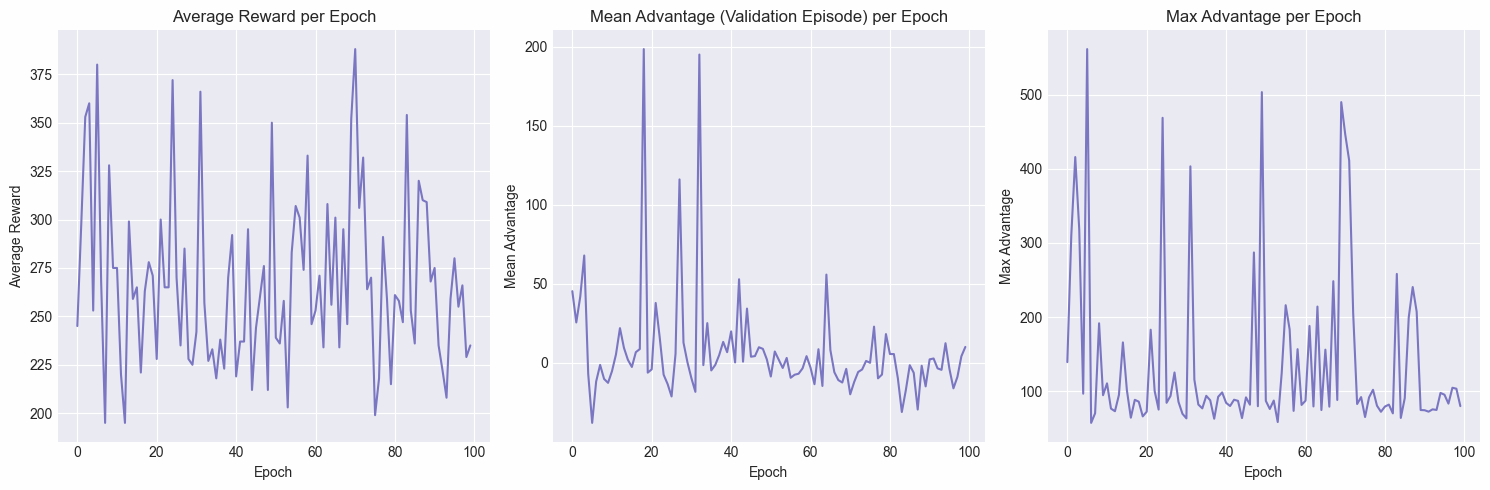

In [81]:
_ = train_reinforce_baseline(env, input_shape, n_actions, total_episodes=1000, num_epochs=100, gamma=0.99, lr=1e-4)

#### Actor-Critic (однокроковий)

<img src='actor_critic.png' width='800'>

In [86]:
def train_actor_critic(env, input_shape, n_actions, num_epochs, total_episodes, gamma=0.99, lr=1e-4, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    actor_critic_net = ActorCriticNetwork(input_shape, n_actions).to(device)

    optimizer = optim.Adam(actor_critic_net.parameters(), lr=lr)

    avg_scores = []
    avg_advantages = []
    max_advantages = []
    validation_avg_advantages = []
    validation_max_advantages = []

    episodes_per_epoch = total_episodes // num_epochs

    for epoch in range(num_epochs):
        total_rewards = []
        advantages = []

        for episode in range(episodes_per_epoch):
            state, _ = env.reset()
            state = preprocess_frame(state).unsqueeze(0).to(device)
            log_probs = []
            rewards = []
            values = []
            done = False
            I = 1.0

            while not done:
                policy, value = actor_critic_net(state)
                action = torch.multinomial(policy, 1).item()
                log_prob = torch.log(policy[0, action])

                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                next_state = preprocess_frame(next_state).unsqueeze(0).to(device)

                with torch.no_grad():
                    next_value = 0 if done else actor_critic_net(next_state)[1]  # якщо термінальний стан, то value = 0
                    
                delta = reward + gamma * next_value - value

                policy_loss = -I * log_prob * delta

                value_loss = delta.pow(2)

                loss = policy_loss + value_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                I *= gamma

                log_probs.append(log_prob.unsqueeze(0))
                rewards.append(reward)
                values.append(value)

                state = next_state

            total_rewards.append(sum(rewards))

        avg_scores.append(np.mean(total_rewards))

        state, _ = env.reset()
        state = preprocess_frame(state).unsqueeze(0).to(device)
        validation_advantages = []
        rewards = []
        values = []
        done = False

        while not done:
            with torch.no_grad():
                policy, value = actor_critic_net(state)
                action = torch.multinomial(policy, 1).item()

                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                next_state = preprocess_frame(next_state).unsqueeze(0).to(device)

                rewards.append(reward)
                values.append(value)

                state = next_state

        returns = compute_returns(rewards, gamma)
        returns = torch.tensor(returns, dtype=torch.float32).unsqueeze(1).to(device)
        values = torch.cat(values)
        validation_advantage = (returns - values).detach().cpu().numpy()

        validation_avg_advantages.append(np.mean(validation_advantage))
        validation_max_advantages.append(np.max(validation_advantage))

        print(f"Epoch {epoch + 1}/{num_epochs}, Avg Reward: {avg_scores[-1]}, "
              f"Validation Avg Advantage: {validation_avg_advantages[-1]}, Max Advantage: {validation_max_advantages[-1]}")

    torch.save(actor_critic_net.state_dict(), "actor_critic_net_final.pth")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(avg_scores)
    plt.title("Average Reward per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Reward")

    plt.subplot(1, 3, 2)
    plt.plot(validation_avg_advantages, label="Validation Avg Advantage")
    plt.legend()
    plt.title("Validation Average Advantage per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Advantage")

    plt.subplot(1, 3, 3)
    plt.plot(validation_max_advantages, label="Validation Max Advantage")
    plt.legend()
    plt.title("Validation Max Advantage per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Max Advantage")

    plt.tight_layout()
    plt.show()

Epoch 1/100, Avg Reward: 291.0, Avg Advantage: 45.05278396606445, Validation Avg Advantage: 39.79423904418945
Epoch 2/100, Avg Reward: 237.0, Avg Advantage: 38.565589904785156, Validation Avg Advantage: 39.901309967041016
Epoch 3/100, Avg Reward: 236.0, Avg Advantage: 37.46161651611328, Validation Avg Advantage: 30.801132202148438
Epoch 4/100, Avg Reward: 221.0, Avg Advantage: 29.946470260620117, Validation Avg Advantage: 24.845483779907227
Epoch 5/100, Avg Reward: 348.0, Avg Advantage: 14.284289360046387, Validation Avg Advantage: -1.6155810356140137
Epoch 6/100, Avg Reward: 251.0, Avg Advantage: -12.26087474822998, Validation Avg Advantage: -31.997325897216797
Epoch 7/100, Avg Reward: 374.0, Avg Advantage: 11.245787620544434, Validation Avg Advantage: -17.295595169067383
Epoch 8/100, Avg Reward: 316.0, Avg Advantage: -0.37232890725135803, Validation Avg Advantage: 1.8563281297683716
Epoch 9/100, Avg Reward: 270.0, Avg Advantage: 3.1705713272094727, Validation Avg Advantage: -19.50563

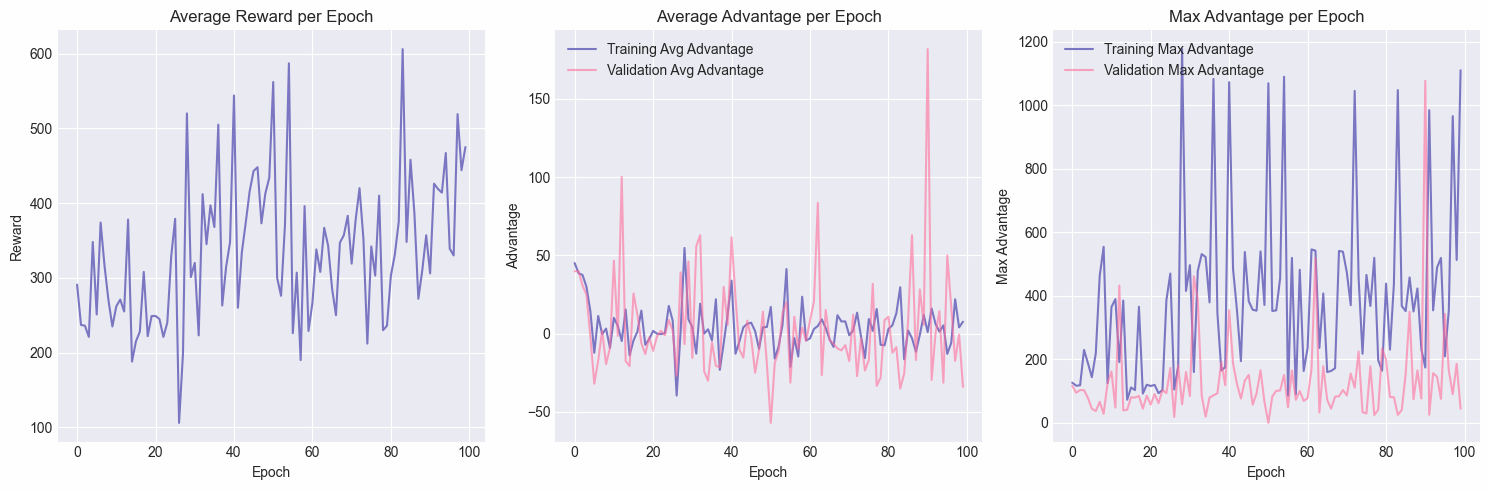

In [23]:
train_actor_critic(env, input_shape, n_actions, num_epochs=100, total_episodes=1000, gamma=0.99, lr=1e-4)

#### 2. Для кожного з методів навчання агента, провести тестування, запустивши $100$ епізодів. Виведіть на екран два графіки: винагорода та тривалість епізоду. Також для епізодів $№№$ $1$, $randint(1, 100)$ та $100$ виведіть графік винагороди $(score)$, отриманої на кожному кроці епізоду.

#### REINFORCE+baseline

In [85]:
def test_reinforce_baseline(policy_model_path, value_model_path, env_name="ALE/MsPacman-v5", num_episodes=100):
    env = gym.make(env_name)
    state_shape = (1, 84, 84)
    n_actions = env.action_space.n

    policy_net = PolicyNetwork(state_shape, n_actions).to("cuda")
    value_net = ValueNetwork(state_shape).to("cuda")

    policy_net.load_state_dict(torch.load(policy_model_path, weights_only=True))
    value_net.load_state_dict(torch.load(value_model_path, weights_only=True))

    policy_net.eval()
    value_net.eval()

    rewards = []
    episode_lengths = []
    scores_data = {}

    random_episode = random.randint(1, num_episodes)

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_frame(state).unsqueeze(0).to("cuda")
        done = False

        episode_reward = 0
        episode_length = 0
        scores_per_step = []

        while not done:
            with torch.no_grad():
                probs = policy_net(state)
                action = torch.multinomial(probs, 1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state).unsqueeze(0).to("cuda")

            episode_reward += reward
            scores_per_step.append(episode_reward)

            state = next_state
            episode_length += 1
            done = terminated or truncated

        rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        if episode in {1, random_episode, num_episodes}:
            scores_data[episode] = scores_per_step

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(rewards, label="Reward")
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths, label="Episode Length")
    plt.title("Episode Length per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Length")

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for idx, episode in enumerate([1, random_episode, num_episodes]):
        axs[idx].plot(scores_data[episode], label=f"Episode {episode} Score")
        axs[idx].set_title(f"Scores per Step (Episode {episode})")
        axs[idx].set_xlabel("Step")
        axs[idx].set_ylabel("Score")
        axs[idx].legend()

    plt.tight_layout()
    plt.show()

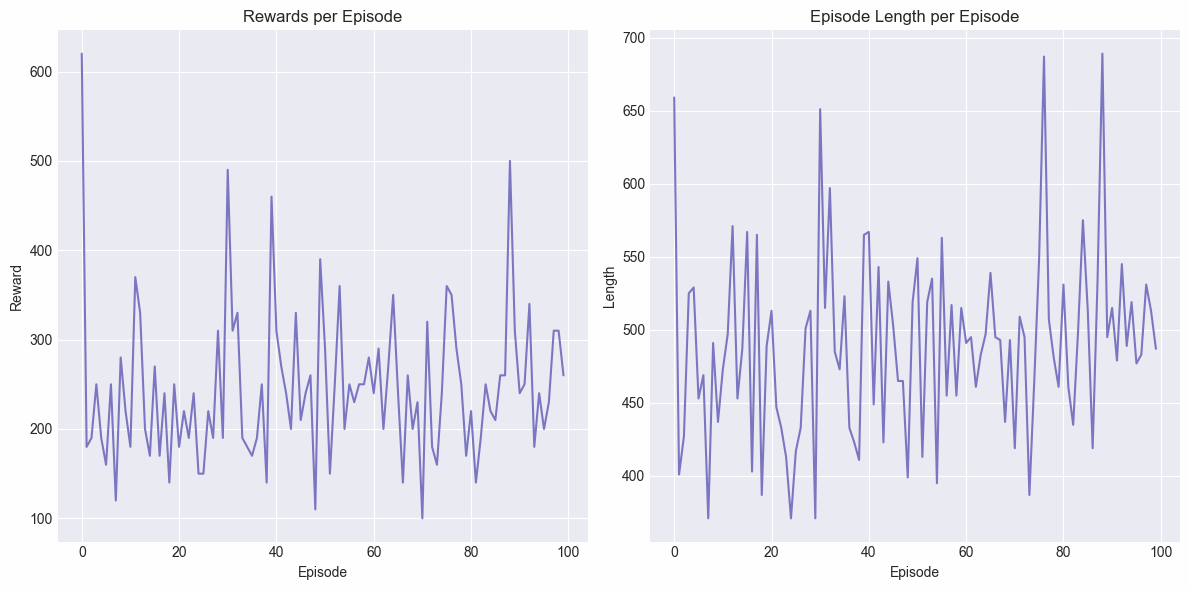

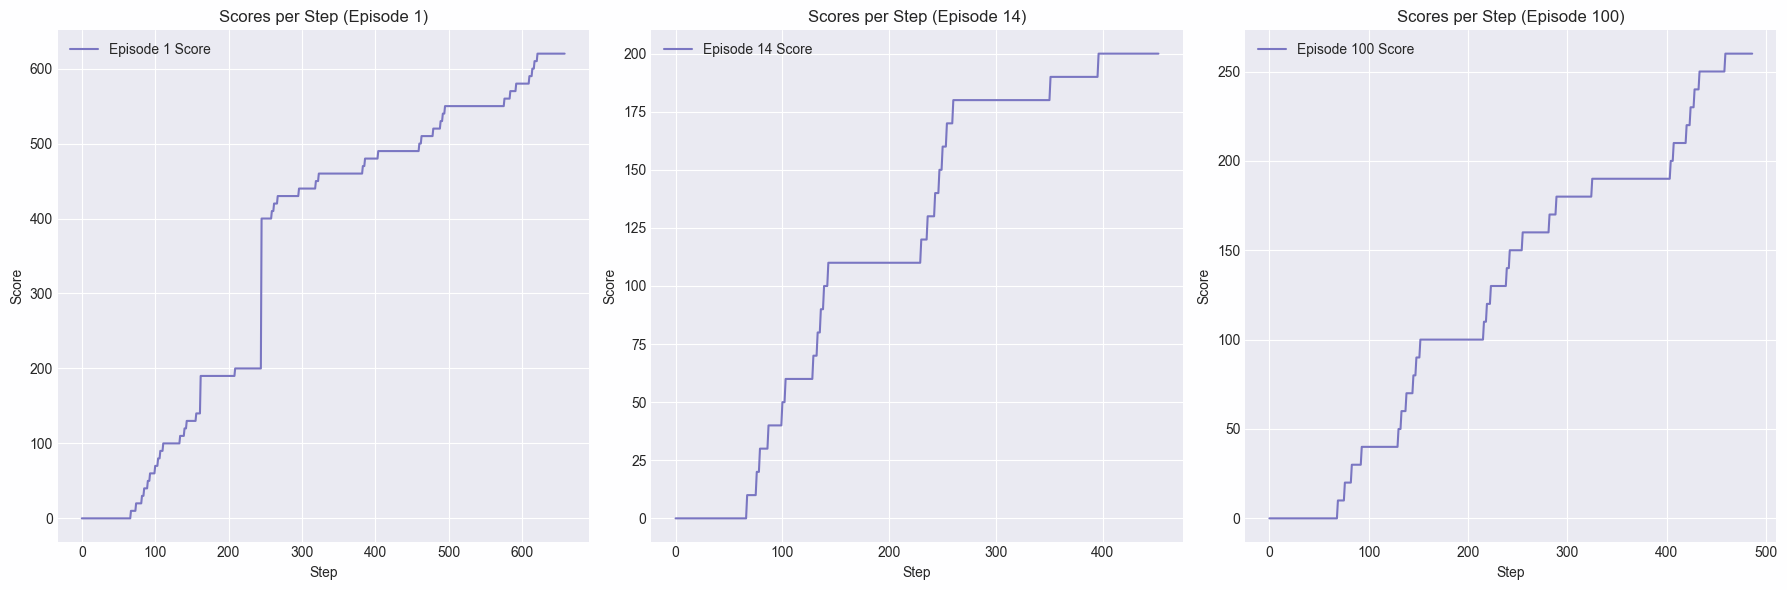

In [56]:
test_reinforce_baseline("policy_net.pth", "value_net.pth", num_episodes=100)

#### Actor-Critic (однокроковий)

In [84]:
def test_actor_critic(model_path, env_name="ALE/MsPacman-v5", num_episodes=100):
    env = gym.make(env_name)
    state_shape = (1, 84, 84)
    n_actions = env.action_space.n

    actor_critic_net = ActorCriticNetwork(state_shape, n_actions).to("cuda")
    actor_critic_net.load_state_dict(torch.load(model_path, weights_only=True))
    actor_critic_net.eval()

    rewards = []
    episode_lengths = []
    scores_data = {}

    random_episode = random.randint(1, num_episodes)

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_frame(state).unsqueeze(0).to("cuda")
        done = False

        episode_reward = 0
        episode_length = 0
        scores_per_step = []

        while not done:
            with torch.no_grad():
                policy, _ = actor_critic_net(state)
                action = torch.multinomial(policy, 1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state).unsqueeze(0).to("cuda")

            episode_reward += reward
            scores_per_step.append(episode_reward)

            state = next_state
            episode_length += 1
            done = terminated or truncated

        rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        if episode in {1, random_episode, num_episodes}:
            scores_data[episode] = scores_per_step

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(rewards, label="Reward")
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths, label="Episode Length")
    plt.title("Episode Length per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Length")

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for idx, episode in enumerate([1, random_episode, num_episodes]):
        axs[idx].plot(scores_data[episode], label=f"Episode {episode} Score")
        axs[idx].set_title(f"Scores per Step (Episode {episode})")
        axs[idx].set_xlabel("Step")
        axs[idx].set_ylabel("Score")
        axs[idx].legend()

    plt.tight_layout()
    plt.show()

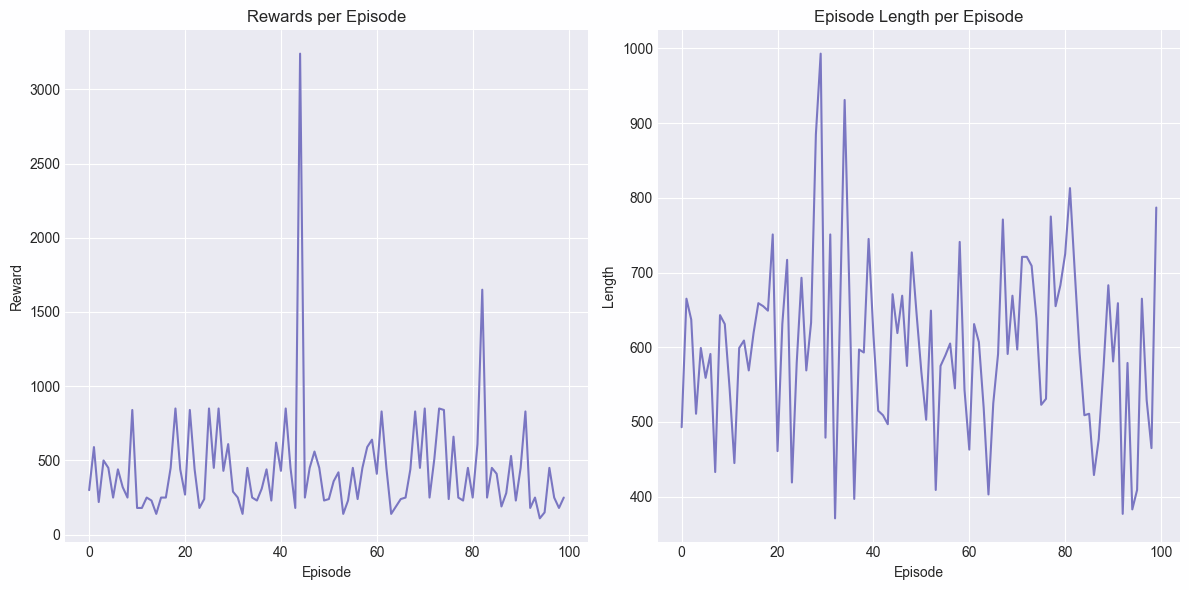

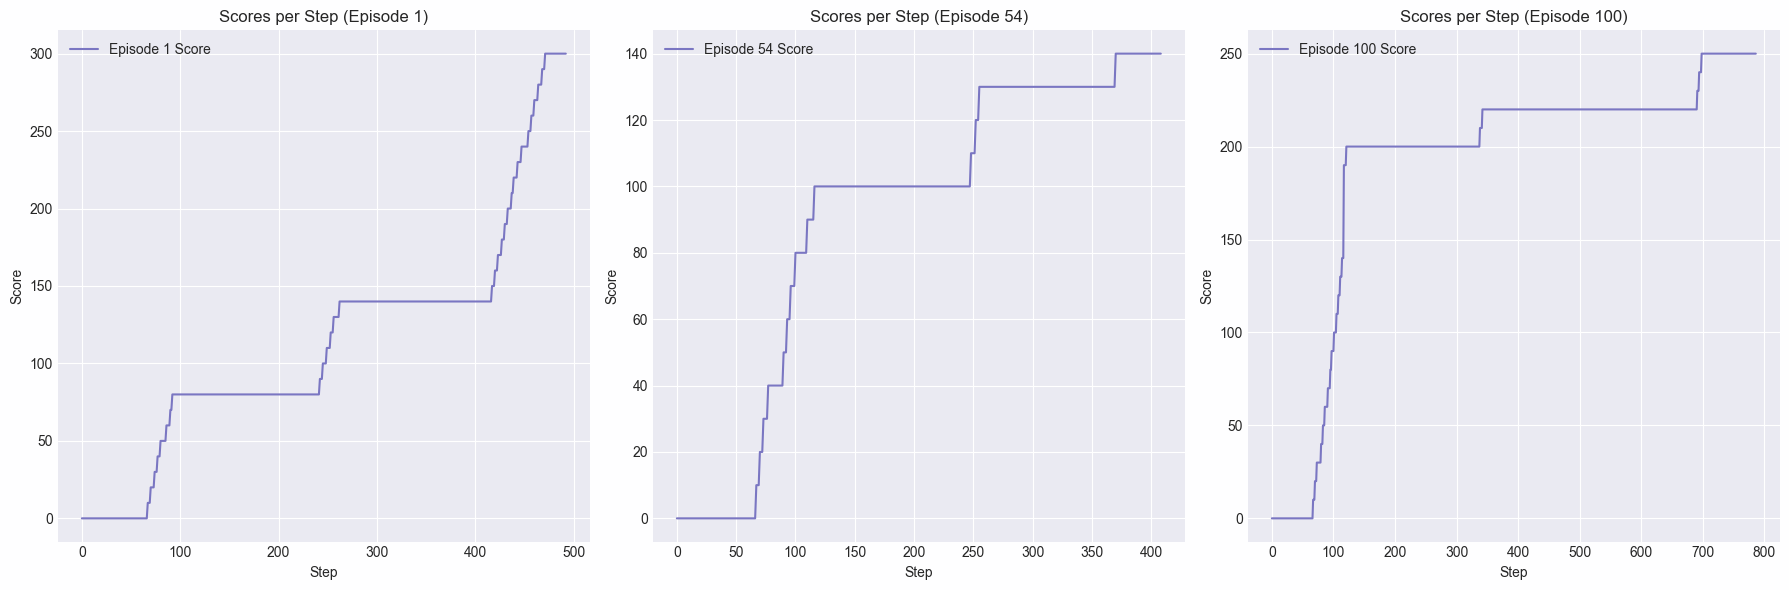

In [60]:
test_actor_critic("actor_critic_net_final.pth", num_episodes=100)

#### 3. Порівняйте результати, отримані у даній роботі, з відповідними результатами, отриманими у ЛР2, і зробіть висновки.

REINFORCE+baseline та однокроковий Actor-Critic змогли навчитися грати в Pacman на базовому рівні, але вони не здатні досягти високої продуктивності через високу дисперсію градієнтів (REINFORCE+baseline), що призводить до повільного навчання та нестабільності, та обмежений горизонт (однокроковий Actor-Critic), що є проблемою в Pacman, адже стратегічне планування на кілька кроків вперед є надважливим.

Pacman має стохастичну природу (рухи привидів, випадкове розміщення вишеньок), що ще більше збільшує дисперсію. Окрім того гра може тривати досить довго, що збільшує час навчання та дисперсію в REINFORCE. Ну і ефективна гра в Pacman вимагає планування на кілька кроків вперед, що є складним для однокрокових методів.

Порівнюючи з результатами у попередній лабораторній роботі, Deep Q-Network (DQN) та її модифікаціями (Fixed Targets, Experience Replay) показали кращі результати і краще впорались з проблемами (викликами) середовища.